# Comparing OLS and LASSO Slope Coefficients: A Monte Carlo Simulation

By Seth Lindokken

## Goal

The goal of this note is to illustrate the trade-offs between OLS and LASSO methods for linear regression on a particular dataset. 

## Summary of Linear Regression, OLS, and LASSO

Linear regression seeks to predict/explain the behavior of a (continuous) target variable in terms of one or more predictor variables using a linear function. In short, given a target variable $Y$ and predictor variables $X_{1},...,X_{p}$, we construct a model

$\hat{Y} = \hat{\beta_{0}} + \hat{\beta_{1}}X_{1} + ... + \hat{\beta_{p}}X_{p}$

that approximates the true population model

$Y = \beta_{0} + \beta_{1}X_{1} + ... + \beta_{p}X_{p} + \epsilon$

where $\beta_{j}$ represents the change in $Y$ given an increase in $X_{j}$ of 1 (holding all other predictor variables constant), $\epsilon$ represents the part of $Y$ that is unexplained by the $X_{i}$'s, and $\beta_{0}$ is a correction factor.

While there are a variety of approaches for estimating these model parameters, two of the most common are Ordinary Least Squares (OLS) and Least Absolute Shrinkage and Selection Operator (LASSO).

OLS is arguably the most common approach, and for good reason. The Gauss-Markov Theorem states that OLS produces unbiased estimates of the $\beta_{j}$'s. Moreover, it states that among all unbiased estimates, the estimates produced by OLS have the lowest variance.

LASSO (popularized by Tibshirani, 1996) provides a certain trade-off. It uses a similar optimizataion scheme as OLS, but imposes a restriction on the total magnitude of the slope coefficients. On the one hand, this restriction will produce biased estimates. On the other hand, it will often provide a desirable reduction in the variance of the estimates.

## Methods

Using data from various countries compiled by the World Health Organization (which can be found [here](https://www.kaggle.com/kumarajarshi/life-expectancy-who) on Kaggle, thanks to user KamarRajarshi), we will form our simulated population and fit a population regression model. This model will use a variety of health indicators to explain life expectancy. The explanatory variable we wish to analyze is HIV/AIDS (which measures the prevalence of HIV/AIDS related deaths in a given country).

Our analysis of the HIV/AIDS slope coefficients under OLS and LASSO regression will be facilitated by a Monte Carlo simulation. We will take repeated samples from the population and train OLS and LASSO regression models on each sample, recording the HIV/AIDS slope coefficients from each model. Finally, we will analyze the distribution of the resulting slope coefficients.

## Note

For additional information on linear regression, including specifics on OLS and LASSO, see [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/), among many others.

## Constructing the Population

We begin by importing the usual libraries and reading in the data.

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [46]:
life = pd.read_csv('Life Expectancy Data.csv')
life.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


While an earnest, top-to-bottom analysis of the data would likely warrant a more intentional treatment of missing data, for our purposes we will be content with simply dropping it.

There were two columns (Polio and Diphtheria) that appear to have minor data entry issues. A handful of entries from each indicated vaccination rates below 10%, which were almost certainly intended to be 10 times the value that was entered. We adjust accordingly. 

On the other hand, a quick perusal of remaining the data shows that certain columns have significant accuracy issues that are essentially beyond salvaging. We will eliminate these as well.

In [47]:
life.dropna(inplace=True)

In [48]:
life['Polio'] = life['Polio'].apply(lambda x: x*10 if x < 10 else x)
life['Diphtheria '] = life['Diphtheria '].apply(lambda x: x*10 if x < 10 else x)

In [49]:
life.drop(columns=['Country','Status','Measles ','GDP','Population', 
                   ' BMI ','percentage expenditure','infant deaths','under-five deaths ',
                   'Adult Mortality',' thinness  1-19 years'],axis=1,inplace=True)

In [50]:
life['Year'],life['Life expectancy '] = life['Life expectancy '],life['Year']
col_list = list(life)
col_list[0],col_list[1] = col_list[1],col_list[0]
life.columns = col_list

In [51]:
life.head()

,Life expectancy,Year,Alcohol,Hepatitis B,Polio,Total expenditure,Diphtheria,HIV/AIDS,thinness 5-9 years,Income composition of resources,Schooling
0,65.0,2015,0.01,65.0,60.0,8.16,65.0,0.1,17.3,0.479,10.1
1,59.9,2014,0.01,62.0,58.0,8.18,62.0,0.1,17.5,0.476,10.0
2,59.9,2013,0.01,64.0,62.0,8.13,64.0,0.1,17.7,0.470,9.9
3,59.5,2012,0.01,67.0,67.0,8.52,67.0,0.1,18.0,0.463,9.8
4,59.2,2011,0.01,68.0,68.0,7.87,68.0,0.1,18.2,0.454,9.5


As evidenced by the plot below, there is a non-linear relationship between Life expectancy and HIV/AIDS. To remedy this (at least partially), we perform a log transform of the HIV/AIDS column.

C:\Users\lindset\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


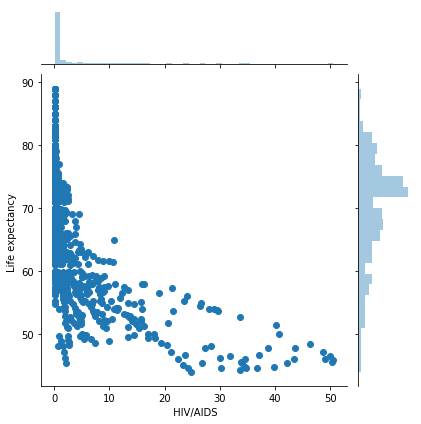

In [52]:
sns.jointplot(x=' HIV/AIDS',y='Life expectancy ',data=life)

In [53]:
life[' HIV/AIDS'] = np.log(life[' HIV/AIDS'])

C:\Users\lindset\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


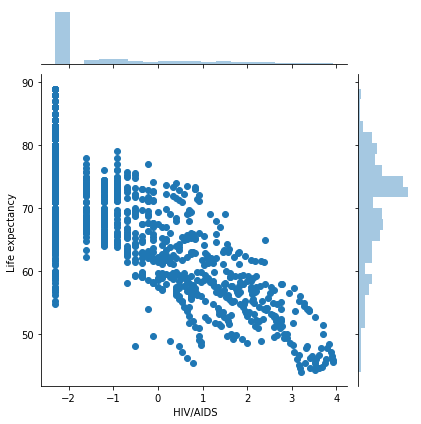

In [54]:
sns.jointplot(x=' HIV/AIDS',y='Life expectancy ',data=life)

Next we import our linear models: OLS Regression and LASSO Regression. Due to LASSO's sensitivity to scale, we will also need to scale our predictor variables.

In [55]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,Lasso

In [56]:
feat = life[life.columns[1:]]
scaler = StandardScaler()
scaler.fit(feat)
scaled_features = scaler.transform(feat)

In [57]:
X = pd.DataFrame(scaled_features,columns=feat.columns)
y = life[['Life expectancy ']].reset_index().drop(columns=['index'])
life = y.join(X)

The "life" dataframe now serves as our population.

In [58]:
life.head()

,Life expectancy,Year,Alcohol,Hepatitis B,Polio,Total expenditure,Diphtheria,HIV/AIDS,thinness 5-9 years,Income composition of resources,Schooling
0,65.0,1.751998,-1.122948,-0.555446,-2.235644,0.958840,-1.833131,-0.680808,2.663654,-0.833462,-0.722799
1,59.9,1.507289,-1.122948,-0.672648,-2.396041,0.967541,-2.073172,-0.680808,2.706643,-0.849853,-0.758583
2,59.9,1.262579,-1.122948,-0.594514,-2.075246,0.945790,-1.913145,-0.680808,2.749632,-0.882634,-0.794367
3,59.5,1.017869,-1.122948,-0.477312,-1.674252,1.115452,-1.673104,-0.680808,2.814116,-0.920878,-0.830151
4,59.2,0.773159,-1.122948,-0.438245,-1.594054,0.832682,-1.593091,-0.680808,2.857105,-0.970049,-0.937503


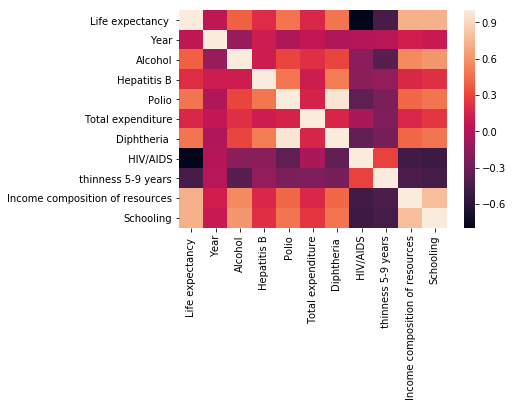

In [59]:
sns.heatmap(life.corr())

## The Population Regression Model

We now obtain the population slope coefficients.

In [60]:
popmodel = LinearRegression()
popmodel.fit(X,y)
pop_coeff = pd.DataFrame(popmodel.coef_.reshape(10,),X.columns,columns=['Population Slope Coefficients'])

In [61]:
pop_coeff

,Population Slope Coefficients
Year,0.132723
Alcohol,0.002938
Hepatitis B,-0.417175
Polio,-0.657246
Total expenditure,0.329635
Diphtheria,1.549068
HIV/AIDS,-4.752983
thinness 5-9 years,-0.736267
Income composition of resources,2.105787
Schooling,1.564463


## The Monte Carlo Simulation

Having established the population parameters, we may begin our investigation in earnest. As discussed before, we wish to compare the behavior of the "HIV/AIDS" coefficient under OLS and LASSO.

We will perform a Monte Carlo simulation in which we take random samples from our population and use them to train OLS/LASSO models. We then record the resulting "HIV/AIDS" slope coefficients.

In [62]:
def OLS_Lasso_MonteCarlo(data, sample_size = 50, num_trials = 50):
    
    # Create an empty DataFrame where we will store our results
    slopes = pd.DataFrame(columns = ['OLS Coefficients','LASSO Coefficients'])
    
    for i in range(num_trials):
        
        # Select a random sample from the population
        temp_data = data.sample(n = sample_size, random_state = i)
        
        # Fit an OLS model to the sample and record the HIV/AIDS slope coefficient
        ols = LinearRegression()
        ols_model = ols.fit(temp_data.iloc[:,1:],temp_data.iloc[:,0:1])
        ols_slope = ols_model.coef_[0][6]
        
        # Fit a LASSO model to the sample and record the HIV/AIDS slope coefficient
        lasso = Lasso(alpha=0.1)
        lasso_model = lasso.fit(temp_data.iloc[:,1:],temp_data.iloc[:,0:1])
        lasso_slope = lasso_model.coef_[6]
        
        # Add the slope coefficients to the DataFrame
        new_row = pd.DataFrame([[ols_slope,lasso_slope]],columns = ['OLS Coefficients','LASSO Coefficients'])
        slopes = slopes.append(new_row,ignore_index=True)
    
    return slopes

slopes = OLS_Lasso_MonteCarlo(life, sample_size = 50, num_trials = 1000)

In [63]:
slopes.head()

,OLS Coefficients,LASSO Coefficients
0,-5.723455,-5.691964
1,-5.302221,-5.381181
2,-4.956983,-4.985749
3,-3.955973,-4.360399
4,-3.761854,-3.782387


## Analyzing the Results

Having collected our slope coefficients, we may begin to analyze the results. First, we use a scatterplot to visualize how the OLS/LASSO coefficients compared on a sample-by-sample basis.

C:\Users\lindset\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


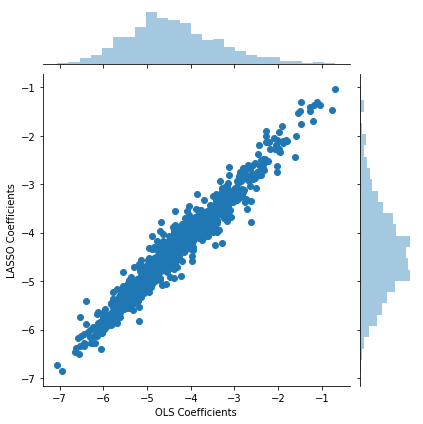

In [64]:
sns.jointplot(x='OLS Coefficients', y='LASSO Coefficients', data=slopes)

Next, we graph the distributions of the OLS Coefficients and the LASSO Coefficients.

C:\Users\lindset\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


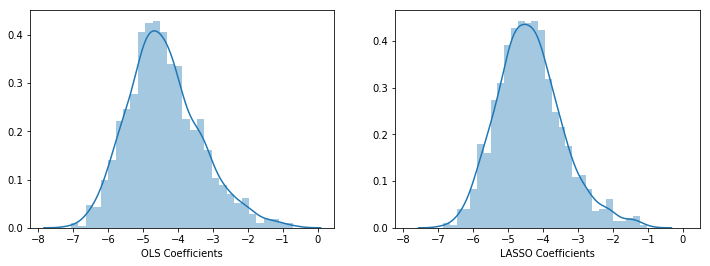

In [65]:
f, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

sns.distplot(slopes['OLS Coefficients'], bins=30, ax=axes[0])
sns.distplot(slopes['LASSO Coefficients'], bins=30, ax=axes[1])

Finally, we compare the means and variances of the OLS/Lasso slope coefficients.

In [66]:
slopes['OLS Coefficients'].mean()

-4.391845156576794

In [67]:
slopes['LASSO Coefficients'].mean()

-4.370066325339527

In [68]:
slopes['OLS Coefficients'].var()

1.084964298179511

In [69]:
slopes['LASSO Coefficients'].var()

0.8881079094550979

## Conclusion

We can see that, in this case, the LASSO method for fitting linear models performed as advertised. On average, it produced slope coefficients for the HIV/AIDS variable that were slightly farther away from the population slope coefficient (-4.75) than the OLS method. On the other hand, the LASSO method also saw an 18% reduction in the variance of the slope coefficients as compared to the OLS method.

One example certainly does not tell the whole story, but we hope this was an informative illustration/comparison of the OLS and LASSO methods in linear regression.